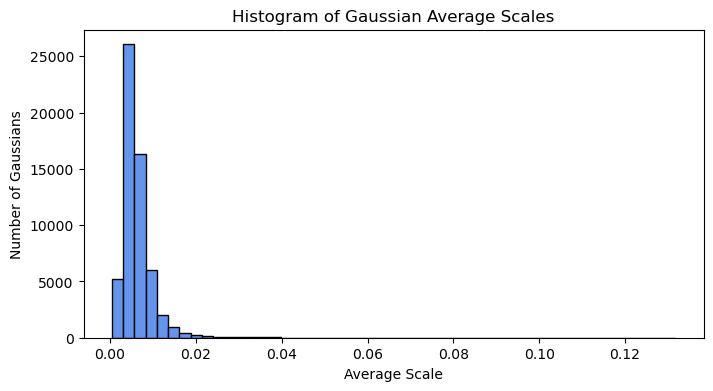

Scale statistics: min = 0.000, median = 0.005, max = 0.132


interactive(children=(FloatLogSlider(value=0.00039873310015536845, continuous_update=False, description='Scale…

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
import ipywidgets as widgets
from ipywidgets import interact, FloatLogSlider

# === 1. Load the NPZ parameter file ===
# Change this filename to match your saved file
param_file = "model_params_masked.npz"
params = np.load(param_file)

# Here we assume the parameters are saved with these keys.
# Adjust the keys if your file uses a different naming convention.
means = params['gauss_params.means']         # shape (N, 3): centers of Gaussians
log_scales = params['gauss_params.scales']     # shape (N, 3): log-scale parameters
quats = params['gauss_params.quats']           # shape (N, 4): quaternions

# === 2. Convert scales from log-space to actual scales ===
# (This mirrors the torch.exp(scales) in the model code.)
scales = np.exp(log_scales)  # shape (N, 3)

# For filtering we can use an average scale per gaussian; you might also use max or another metric.
gaussian_scale = scales.mean(axis=1)  # shape (N,)

# === 3. Convert quaternions to rotation matrices ===
def quats_to_rot_mats(quats):
    """
    Converts a batch of quaternions to rotation matrices.
    Assumes quaternions are in the order [w, x, y, z].
    If your quaternions have a different ordering (e.g., [x,y,z,w]),
    adjust the indices accordingly.
    
    Args:
        quats: numpy array of shape (N, 4)
    Returns:
        rot_mats: numpy array of shape (N, 3, 3)
    """
    # Normalize the quaternions
    norms = np.linalg.norm(quats, axis=1, keepdims=True)
    quats = quats / norms
    w = quats[:, 0]
    x = quats[:, 1]
    y = quats[:, 2]
    z = quats[:, 3]
    R = np.empty((quats.shape[0], 3, 3))
    R[:, 0, 0] = 1 - 2*(y*y + z*z)
    R[:, 0, 1] = 2*(x*y - z*w)
    R[:, 0, 2] = 2*(x*z + y*w)
    R[:, 1, 0] = 2*(x*y + z*w)
    R[:, 1, 1] = 1 - 2*(x*x + z*z)
    R[:, 1, 2] = 2*(y*z - x*w)
    R[:, 2, 0] = 2*(x*z - y*w)
    R[:, 2, 1] = 2*(y*z + x*w)
    R[:, 2, 2] = 1 - 2*(x*x + y*y)
    return R

rot_mats = quats_to_rot_mats(quats)  # shape (N, 3, 3)

# === 4. Generate four points per Gaussian ===
# Here we create a local quad in the Gaussian’s XY plane.
# For each Gaussian, we use its center ("means"), and local offsets in x and y
# based on the corresponding scale along x and y.
# (You may wish to change the offsets or choose a different plane.)
all_quad_points = []  # will collect points for all Gaussians

for i in range(means.shape[0]):
    center = means[i]  # (3,)
    # Use the scale components for x and y directions.
    # Here we take the full scale (not half-extent) and then use half of that for the quad.
    sx, sy, _ = scales[i]
    # Define 4 corners in the local coordinate frame centered at (0,0,0).
    # These corners lie on the XY plane.
    local_corners = np.array([
        [-sx / 2, -sy / 2, 0],
        [ sx / 2, -sy / 2, 0],
        [ sx / 2,  sy / 2, 0],
        [-sx / 2,  sy / 2, 0],
    ])  # shape (4, 3)
    # Rotate the local corners using the Gaussian’s rotation matrix, then translate by its center.
    R = rot_mats[i]  # (3, 3)
    global_corners = (R @ local_corners.T).T + center  # shape (4, 3)
    all_quad_points.append(global_corners)

# Convert list to a single NumPy array
# After this, quad_points has shape (4*N, 3)
quad_points = np.concatenate(all_quad_points, axis=0)

# === 5. Analyze the scale distribution ===
# Plot a simple histogram of the average scales.
plt.figure(figsize=(8, 4))
plt.hist(gaussian_scale, bins=50, color="cornflowerblue", edgecolor="k")
plt.title("Histogram of Gaussian Average Scales")
plt.xlabel("Average Scale")
plt.ylabel("Number of Gaussians")
plt.show()

print(f"Scale statistics: min = {gaussian_scale.min():.3f}, "
      f"median = {np.median(gaussian_scale):.3f}, max = {gaussian_scale.max():.3f}")

# === 6. Create a slider for scale-based filtering ===
#
# The slider is defined on a logarithmic scale because the distribution of scales
# is typically not linear. We use ipywidgets.FloatLogSlider.
# The slider value will be used as a threshold, and we keep only those Gaussians
# with an average scale greater or equal to that value. (Adjust the filtering criteria if needed.)

# Define a function to update the point cloud visualization based on the slider threshold.
def plot_point_cloud(scale_threshold):
    """
    Plots the point cloud of all quad points for Gaussians with an average scale
    above the scale_threshold.
    
    Args:
        scale_threshold (float): The threshold for filtering Gaussian average scale.
    """
    # Determine which Gaussians pass the threshold.
    valid = gaussian_scale >= scale_threshold
    num_valid = np.sum(valid)
    print(f"Displaying {num_valid} out of {len(gaussian_scale)} Gaussians "
          f"(threshold = {scale_threshold:.3f}).")
    
    # Collect points from only the valid Gaussians.
    filtered_quad_points = []
    for i, keep in enumerate(valid):
        if keep:
            # Each gaussian contributes 4 points.
            pts = quad_points[i*4 : i*4 + 4]
            filtered_quad_points.append(pts)
    if filtered_quad_points:
        filtered_quad_points = np.concatenate(filtered_quad_points, axis=0)
    else:
        filtered_quad_points = np.empty((0, 3))
    
    # Plot in 3D.
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    if filtered_quad_points.shape[0] > 0:
        ax.scatter(filtered_quad_points[:, 0],
                   filtered_quad_points[:, 1],
                   filtered_quad_points[:, 2],
                   s=1, c="tomato")
    ax.set_title(f"Point Cloud (Scale threshold = {scale_threshold:.3f})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Define the slider range based on the observed scales.
min_scale_val = gaussian_scale.min()
max_scale_val = gaussian_scale.max()

# Create a logarithmic slider.
scale_slider = FloatLogSlider(
    value=min_scale_val,
    base=10,
    min=np.log10(min_scale_val),
    max=np.log10(max_scale_val),
    step=0.01,
    description='Scale Threshold',
    continuous_update=False,
)

# Use interact to update the point cloud when the slider moves.
interact(plot_point_cloud, scale_threshold=scale_slider);


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


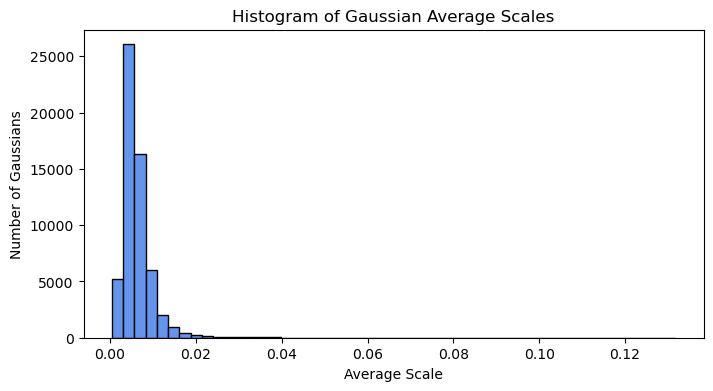

Scale statistics: min = 0.000, median = 0.005, max = 0.132


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, FloatLogSlider, FloatSlider, Dropdown, Checkbox, VBox, HBox, Output

# --- Additional import for surface reconstruction ---
try:
    import open3d as o3d
except ImportError:
    print("Open3D is required for surface reconstruction. Install it via pip install open3d")

# ============================
# 1. Load and process parameters
# ============================
# Change the file name to match your saved NPZ file
param_file = "model_params_masked.npz"
params = np.load(param_file)

# Keys used in the NPZ file – adjust if different.
means = params['gauss_params.means']         # (N, 3) centers of Gaussians
log_scales = params['gauss_params.scales']     # (N, 3) log-scale parameters
quats = params['gauss_params.quats']           # (N, 4) quaternions

# Convert scales from log-space to actual scales.
scales = np.exp(log_scales)  # shape (N, 3)
# Compute a representative (average) scale per Gaussian for filtering.
gaussian_scale = scales.mean(axis=1)  # shape (N,)

# --- Quaternion to rotation matrix conversion ---
def quats_to_rot_mats(quats):
    """
    Converts an array of quaternions to rotation matrices.
    Assumes quaternions are of shape (N,4) in [w, x, y, z] order.
    Modify the order if needed.
    Returns an array of shape (N,3,3).
    """
    norms = np.linalg.norm(quats, axis=1, keepdims=True)
    quats = quats / norms
    w = quats[:, 0]
    x = quats[:, 1]
    y = quats[:, 2]
    z = quats[:, 3]
    R = np.empty((quats.shape[0], 3, 3))
    R[:, 0, 0] = 1 - 2*(y*y + z*z)
    R[:, 0, 1] = 2*(x*y - z*w)
    R[:, 0, 2] = 2*(x*z + y*w)
    R[:, 1, 0] = 2*(x*y + z*w)
    R[:, 1, 1] = 1 - 2*(x*x + z*z)
    R[:, 1, 2] = 2*(y*z - x*w)
    R[:, 2, 0] = 2*(x*z - y*w)
    R[:, 2, 1] = 2*(y*z + x*w)
    R[:, 2, 2] = 1 - 2*(x*x + y*y)
    return R

rot_mats = quats_to_rot_mats(quats)  # shape (N,3,3)

# --- Generate eight points per Gaussian ---
# Here we create a local bounding box for each Gaussian.
# Each box has eight corners defined by ±(scale/2) for x, y, and z.
all_box_points = []  # list to store (8,3) arrays for each Gaussian

for i in range(means.shape[0]):
    center = means[i]  # (3,)
    sx, sy, sz = scales[i]
    # Eight corners of a box centered at (0,0,0)
    local_corners = np.array([
        [-sx/2, -sy/2, -sz/2],
        [ sx/2, -sy/2, -sz/2],
        [ sx/2,  sy/2, -sz/2],
        [-sx/2,  sy/2, -sz/2],
        [-sx/2, -sy/2,  sz/2],
        [ sx/2, -sy/2,  sz/2],
        [ sx/2,  sy/2,  sz/2],
        [-sx/2,  sy/2,  sz/2],
    ])
    # Rotate the box using the Gaussian’s rotation matrix then translate by its center.
    R = rot_mats[i]  # (3,3)
    global_corners = (R @ local_corners.T).T + center  # (8,3)
    all_box_points.append(global_corners)
    
# Concatenate into a point cloud: shape (8*N, 3)
box_points = np.concatenate(all_box_points, axis=0)

# --- Analyze scale distribution ---
plt.figure(figsize=(8, 4))
plt.hist(gaussian_scale, bins=50, color="cornflowerblue", edgecolor="k")
plt.title("Histogram of Gaussian Average Scales")
plt.xlabel("Average Scale")
plt.ylabel("Number of Gaussians")
plt.show()

print(f"Scale statistics: min = {gaussian_scale.min():.3f}, median = {np.median(gaussian_scale):.3f}, max = {gaussian_scale.max():.3f}")

# ============================
# 2. Interactive Point Cloud Filtering
# ============================
# Create widgets for the slider type, threshold, and inversion.
slider_type = Dropdown(options=['Logarithmic', 'Linear'], value='Logarithmic', description='Slider type:')
# Two threshold sliders, one linear and one logarithmic.
linear_slider = FloatSlider(
    value=float(gaussian_scale.min()),
    min=float(gaussian_scale.min()),
    max=float(gaussian_scale.max()),
    step=(float(gaussian_scale.max())-float(gaussian_scale.min()))/100,
    description='Threshold:',
    continuous_update=False,
)
log_slider = FloatLogSlider(
    value=float(gaussian_scale.min()),
    base=10,
    min=np.log10(gaussian_scale.min()),
    max=np.log10(gaussian_scale.max()),
    step=0.01,
    description='Threshold:',
    continuous_update=False,
)
# Initially show only the logarithmic slider.
linear_slider.layout.display = 'none'

# A checkbox to invert the filter.
invert_checkbox = Checkbox(value=False, description='Invert Filter')

# Global variable for storing the currently filtered point cloud.
filtered_points = None

# Create an output area for the point cloud plot.
out_pc = Output()

def update_slider_visibility(change=None):
    """Toggle visibility of linear vs. logarithmic slider based on dropdown."""
    if slider_type.value == "Linear":
        linear_slider.layout.display = 'block'
        log_slider.layout.display = 'none'
    else:
        linear_slider.layout.display = 'none'
        log_slider.layout.display = 'block'
slider_type.observe(update_slider_visibility, names='value')
update_slider_visibility()

def update_point_cloud(*args):
    """Update the point cloud plot based on the current threshold and filter mode."""
    global filtered_points
    # Choose the current threshold from the visible slider.
    current_threshold = log_slider.value if slider_type.value == "Logarithmic" else linear_slider.value
    # If the filter is inverted, we keep Gaussians with average scale below the threshold.
    if invert_checkbox.value:
        valid = gaussian_scale <= current_threshold
    else:
        valid = gaussian_scale >= current_threshold
    num_valid = np.sum(valid)
    print_msg = f"Displaying {num_valid} out of {len(gaussian_scale)} Gaussians (threshold = {current_threshold:.3f})."
    
    # Gather points only from valid Gaussians.
    valid_points_list = []
    # Each Gaussian contributes 8 points; we assume the order in box_points is the same as in gaussian_scale.
    for i, keep in enumerate(valid):
        if keep:
            pts = box_points[i*8 : i*8 + 8]
            valid_points_list.append(pts)
    if valid_points_list:
        filtered_points = np.concatenate(valid_points_list, axis=0)
    else:
        filtered_points = np.empty((0, 3))
    
    # Plot in a 3D matplotlib figure.
    with out_pc:
        out_pc.clear_output(wait=True)
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        if filtered_points.shape[0] > 0:
            ax.scatter(filtered_points[:, 0],
                       filtered_points[:, 1],
                       filtered_points[:, 2],
                       s=1, c="tomato")
        ax.set_title(print_msg)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()

# Set up observers so that changes in any widget update the plot.
for widget_item in [linear_slider, log_slider, slider_type, invert_checkbox]:
    widget_item.observe(update_point_cloud, names='value')
    
# Call once to display the initial point cloud.
update_point_cloud()

# ============================
# 3. Surface Reconstruction from Filtered Point Cloud
# ============================
# Create a slider for the alpha parameter controlling the alpha-shape reconstruction.
alpha_slider = FloatSlider(
    value=0.1,
    min=0.01,
    max=1.0,
    step=0.01,
    description='Alpha:',
    continuous_update=False,
)
# Output area for the mesh plot.
out_mesh = Output()

def reconstruct_mesh_from_points(points, alpha):
    """
    Uses Open3D's alpha shape method to reconstruct a mesh from a point cloud.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    # Create mesh using the alpha-shape algorithm.
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    mesh.compute_vertex_normals()
    return mesh

def plot_mesh(mesh):
    """
    Plots a mesh using matplotlib's 3D Poly3DCollection.
    """
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the vertices.
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='b', s=1)
    # Create a collection for the mesh faces.
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    if triangles.shape[0] > 0:
        mesh_collection = Poly3DCollection(vertices[triangles], alpha=0.5, edgecolor='k')
        ax.add_collection3d(mesh_collection)
    ax.set_title(f"Surface Reconstruction (alpha = {alpha_slider.value:.3f})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

def update_mesh(change):
    """Update the surface mesh plot based on the current filtered points and alpha parameter."""
    with out_mesh:
        out_mesh.clear_output(wait=True)
        if filtered_points is None or filtered_points.shape[0] == 0:
            print("No points available for surface reconstruction. Adjust the filter threshold.")
            return
        try:
            mesh = reconstruct_mesh_from_points(filtered_points, alpha_slider.value)
            plot_mesh(mesh)
        except Exception as e:
            print("Surface reconstruction failed:", e)

# Observe changes in the alpha slider.
alpha_slider.observe(update_mesh, names='value')
# Also update the mesh whenever the point cloud changes.
# (This uses a custom call below.)
def update_mesh_from_pc(*args):
    update_mesh(None)
for widget_item in [linear_slider, log_slider, slider_type, invert_checkbox]:
    widget_item.observe(update_mesh_from_pc, names='value')
    
# Call once to display the initial mesh.
update_mesh(None)

# ============================
# Display all widgets
# ============================
ui = VBox([
    HBox([slider_type, invert_checkbox]),
    log_slider, linear_slider,
    out_pc,
    widgets.Label("Surface Reconstruction:"),
    alpha_slider,
    out_mesh
])

display(ui)
